# Shakespeare GPT

## Building a Playwright from Scratch

In this notebook, we are going to apply the **Self-Attention** mechanism to a classic problem: teaching a computer to write like William Shakespeare.

Unlike previous toy examples, we will use **real data**—the famous "TinyShakespeare" dataset. You will see how a Transformer model captures the rhythm, old-English vocabulary, and dramatic structure of the Bard's plays.

### What You Will Learn:
1. **Real Data Handling**: Downloading and cleaning raw text data.
2. **Efficient Tokenization**: Handling a large vocabulary of Old English words.
3. **Batching**: Using PyTorch DataLoaders to train on thousands of sentences.
4. **Temperature Sampling**: How to make the model creative vs. predictable.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import re
from collections import Counter
import matplotlib.pyplot as plt

# Set device (GPU is highly recommended for this notebook)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

torch.manual_seed(1337)

Device: cuda


## 1. Acquiring the Manuscript

First, we need the text. We will download the `tinyshakespeare.txt` file, which contains snippets from plays like *Hamlet*, *Romeo & Juliet*, and *Othello*.

In [7]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
data = requests.get(url).text

print(f"Total characters: {len(data)}")
print("--- First 200 characters ---")
print(data[:200])

# FOR SPEED: We will limit the dataset to the first 50,000 characters for this educational demo.
# If you have a GPU and time, you can remove this limit!
#train_text = data[:50000]
train_text = data[:]
print(f"\nTraining on first {len(train_text)} characters.")

Total characters: 1115394
--- First 200 characters ---
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you

Training on first 1115394 characters.


## 2. Tokenization: Handling Old English

Shakespeare uses complex punctuation and contractions (e.g., *'tis*, *thou*). 

We will build a tokenizer that:
1. Lowercases the text.
2. Keeps punctuation as separate tokens (so the model learns where sentences end).
3. Filters out very rare words to keep our model small and fast.

In [8]:
class ShakespeareTokenizer:
    def __call__(self, text):
        # Regex explanation:
        # \w+ : matches words
        # |   : OR
        # [.,!?;] : matches punctuation marks individually
        return re.findall(r"\w+|[.,!?;]", text.lower())

tokenizer = ShakespeareTokenizer()

# Let's see how it handles a sentence
sample = "To be, or not to be? That is the question."
print(tokenizer(sample))

['to', 'be', ',', 'or', 'not', 'to', 'be', '?', 'that', 'is', 'the', 'question', '.']


### 2.1 Building the Vocabulary

We will now build the dictionary. To prevent the model from exploding in size, we will use a **Frequency Filter**. We only keep words that appear at least 2 times. Everything else becomes `<unk>` (unknown).

In [10]:
def build_vocab(text, tokenizer, min_freq=2):
    tokens = tokenizer(text)
    counts = Counter(tokens)
    
    # Keep words that appear at least min_freq times
    vocab = ['<pad>', '<unk>'] + [word for word, count in counts.items() if count >= min_freq]
    
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for i, w in enumerate(vocab)}
    
    return vocab, word2idx, idx2word

vocab, word2idx, idx2word = build_vocab(train_text, tokenizer)
print(f"Vocabulary Size: {len(vocab)}")
print(f"ID for 'king': {word2idx.get('king', 'Not found')}")

Vocabulary Size: 6545
ID for 'king': 1953


## 3. Creating the Dataset

We need to create thousands of examples for the model.

- **Context Window**: 8 words (The model looks at 8 words to predict the 9th).
- **Batch Size**: 32 (We process 32 sequences at once for speed).

In [16]:
SEQ_LEN = 16  # Length of the context window
BATCH_SIZE = 32

class ShakespeareDataset(Dataset):
    def __init__(self, text, tokenizer, word2idx, seq_len):
        tokens = tokenizer(text)
        # Convert all tokens to IDs immediately
        self.ids = [word2idx.get(t, word2idx['<unk>']) for t in tokens]
        self.seq_len = seq_len

    def __len__(self):
        return len(self.ids) - self.seq_len

    def __getitem__(self, idx):
        # Input: idx to idx+seq_len
        input_seq = torch.tensor(self.ids[idx : idx+self.seq_len], dtype=torch.long)
        # Target: The very next word
        target = torch.tensor(self.ids[idx+self.seq_len], dtype=torch.long)
        return input_seq, target

# Create Dataset and Loader
dataset = ShakespeareDataset(train_text, tokenizer, word2idx, SEQ_LEN)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Total training batches per epoch: {len(loader)}")

Total training batches per epoch: 7640


## 4. The Transformer Architecture

 We will use `nn.MultiheadAttention`, which allows the model to focus on different parts of the sentence simultaneously (e.g., one "head" focuses on grammar, another on which character is speaking).

**Structure:**
1. `Embedding`: Words -> Vectors
2. `PositionalEmbedding`: Adds order information (1st word vs 2nd word).
3. `TransformerBlock`: Self-Attention + Feed Forward Network.
4. `Linear`: Vector -> Prediction of next word.

In [17]:
class ShakespeareGPT(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim=64, num_heads=4):
        super().__init__()
        self.seq_len = seq_len
        
        # 1. Embeddings
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Embedding(seq_len, embed_dim)
        
        # 2. Multi-Head Attention layer
        # batch_first=True means input is [Batch, Seq, Feature]
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # 3. Simple Feed Forward Network
        self.linear1 = nn.Linear(embed_dim, embed_dim * 4)
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(embed_dim)
        
        # 4. Output Head
        self.output_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        B, T = x.shape
        
        # Create positions (0, 1, 2... T-1)
        positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        
        # Combine Word + Position
        x = self.token_embedding(x) + self.pos_embedding(positions)
        
        # Attention Block
        # We pass x as Query, Key, and Value
        attn_out, attn_weights = self.attention(x, x, x)
        
        # Add & Norm (Skip Connection)
        x = self.norm(x + attn_out)
        
        # Feed Forward Block
        ff_out = self.linear2(self.relu(self.linear1(x)))
        
        # Add (Skip Connection)
        x = x + ff_out
        
        # We only care about the prediction of the LAST token in the sequence
        last_token_output = x[:, -1, :]
        
        logits = self.output_head(last_token_output)
        
        return logits, attn_weights

## 5. Training the Bard

We will train for 10 epochs. Since we are using a subset of the data (50k chars), this should be relatively quick.

Watch the `Loss`. If it goes down, the model is learning the structure of the language.

In [18]:
# Initialize Model
model = ShakespeareGPT(len(vocab), SEQ_LEN, embed_dim=128, num_heads=4)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 10

print("--- Starting Rehearsal (Training) ---")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x_batch)
        
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

--- Starting Rehearsal (Training) ---
Epoch 1/10 | Loss: 5.5657
Epoch 2/10 | Loss: 5.0864
Epoch 3/10 | Loss: 4.8710
Epoch 4/10 | Loss: 4.7011
Epoch 5/10 | Loss: 4.5504
Epoch 6/10 | Loss: 4.4177
Epoch 7/10 | Loss: 4.2950
Epoch 8/10 | Loss: 4.1812
Epoch 9/10 | Loss: 4.0778
Epoch 10/10 | Loss: 3.9818


## 6. Generation: Writing a New Play

To generate text, we feed the model a "prompt". It predicts the next word. We add that word to the prompt and repeat.

### The Concept of "Temperature"
Instead of always picking the #1 most likely word (which is boring and repetitive), we sample from the probability distribution.
- **Temperature = 1.0**: Standard sampling.
- **Temperature > 1.0**: High creativity (risk of nonsense).
- **Temperature < 1.0**: High focus (risk of repetition).

In [19]:
def generate_shakespeare(model, prompt, max_words=30, temp=1.0):
    model.eval()
    tokens = tokenizer(prompt)
    
    # Pad if prompt is shorter than SEQ_LEN
    if len(tokens) < SEQ_LEN:
        tokens = ['<pad>'] * (SEQ_LEN - len(tokens)) + tokens
        
    # Convert to IDs
    current_ids = [word2idx.get(w, word2idx['<unk>']) for w in tokens]
    generated_tokens = list(tokens)
    
    with torch.no_grad():
        for _ in range(max_words):
            # Get the last SEQ_LEN ids
            input_tensor = torch.tensor([current_ids[-SEQ_LEN:]], device=device)
            
            # Get predictions
            logits, _ = model(input_tensor)
            
            # Apply Temperature
            logits = logits / temp
            probs = F.softmax(logits, dim=-1)
            
            # Sample from the distribution
            next_token_id = torch.multinomial(probs, 1).item()
            
            # Append to sequence
            current_ids.append(next_token_id)
            generated_tokens.append(idx2word[next_token_id])
            
    # Join tokens nicely (handle punctuation)
    output = " ".join(generated_tokens)
    output = output.replace(" .", ".").replace(" ,", ",").replace(" ?", "?").replace(" !", "!")
    output = output.replace("<pad> ", "")
    
    return output

# Let's generate!
print("--- Generated Act 1 Scene 1 ---")
print(generate_shakespeare(model, "the king said", max_words=40, temp=0.8))

print("\n--- Generated Act 1 Scene 2 ---")
print(generate_shakespeare(model, "where art thou", max_words=40, temp=1.0))

--- Generated Act 1 Scene 1 ---
the king said and stole into the covert many marriage they have seen thy mildness chair, thy brother, and so though many more rightly, banish d by montague. montague what richmond is it so? lord and, sir

--- Generated Act 1 Scene 2 ---
where art thou <unk>. lucio a sense s reason and be i before thee, not thyself honour to thee, behold mine arm, to shame, thou art! kill me, like a pretty priest. katharina a husband


## 7. Peeking into the Brain (Attention Map)

Why did the model choose a specific word? Let's visualize the **Attention Weights**.

This heatmap shows which words in the prompt the model focused on to make its decision. For example, if the prompt is "The King", the model should focus on "King" to predict a verb like "commands" or "speaks".

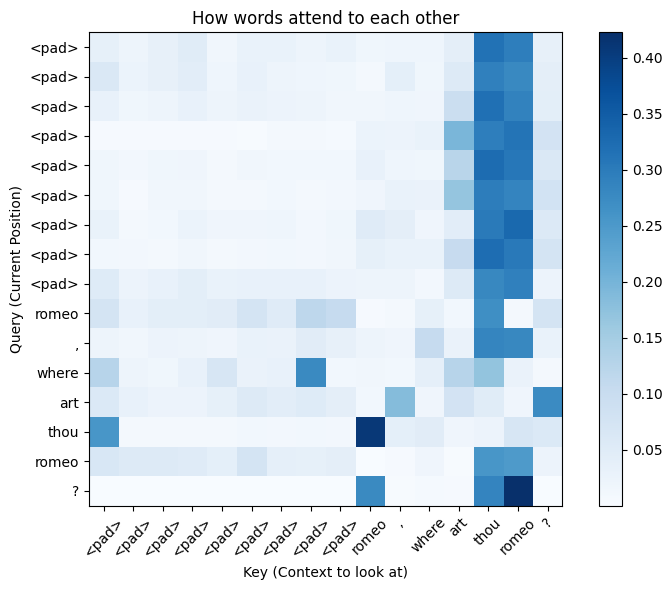

In [20]:
def visualize_attention(prompt):
    model.eval()
    tokens = tokenizer(prompt)
    # Pad if needed
    if len(tokens) < SEQ_LEN:
        tokens = ['<pad>'] * (SEQ_LEN - len(tokens)) + tokens
        
    # Truncate if too long
    tokens = tokens[-SEQ_LEN:]
    
    ids = [word2idx.get(w, word2idx['<unk>']) for w in tokens]
    input_tensor = torch.tensor([ids], device=device)
    
    with torch.no_grad():
        # Get attention weights
        _, attn_weights = model(input_tensor)
        
    # Move to CPU for plotting
    # attn_weights shape: [Batch, Seq, Seq] -> take first batch
    w = attn_weights[0].cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.imshow(w, cmap='Blues')
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.yticks(range(len(tokens)), tokens)
    plt.colorbar()
    plt.title(f"How words attend to each other")
    plt.ylabel("Query (Current Position)")
    plt.xlabel("Key (Context to look at)")
    plt.tight_layout()
    plt.show()

visualize_attention("romeo , where art thou romeo ?")

## Conclusion

You have successfully trained a Transformer on Shakespeare! 

**Key Takeaways:**
1. **Language is Pattern**: The model didn't learn English grammar rules explicitly. It simply learned that "thou" is often followed by "art" or "hast" by seeing it frequently in the data.
2. **Attention is Context**: The attention map shows that to predict the next word, the model doesn't just look at the word immediately before it—it looks at the whole sentence context.

**Challenges for you:**
- Increase `SEQ_LEN` to 16 or 32 to get more coherent sentences.
- Remove the 50,000 character limit and train on the full dataset (will take longer!).
- Try a different author (e.g., Harry Potter or Jane Austen text).